In [2]:
# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model
import splitfolders

import os

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

In [3]:
# Constants
malevis_dir = "/home/odesa/Desktop/EBRAR/malevis_train_val_300x300"
TRAIN_DIR = "/home/odesa/Desktop/EBRAR/malevis300/train"
TEST_DIR = "/home/odesa/Desktop/EBRAR/malevis300/test"
VAL_DIR = "/home/odesa/Desktop/EBRAR/malevis300/val"
SIZE = (200, 200)
COLOR_MODE = "rgb"

In [4]:
'''splitfolders.ratio(os.path.join(malevis_dir, "train"), 
                       "malevis300/",
                       seed = 1337, 
                       ratio = (0.8, 0, 0.2), 
                       group_prefix = None, 
                       move = False)'''

'splitfolders.ratio(os.path.join(malevis_dir, "train"), \n                       "malevis300/",\n                       seed = 1337, \n                       ratio = (0.8, 0, 0.2), \n                       group_prefix = None, \n                       move = False)'

In [5]:
# Create generators based on the preprocessing requirements of the CNN architecture.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.efficientnet.preprocess_input)
test_gen  = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.efficientnet.preprocess_input)
val_gen   = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnns.efficientnet.preprocess_input)

# Read images from the directories
train_images = train_gen.flow_from_directory(
            directory=TRAIN_DIR,
            target_size=SIZE,
            color_mode=COLOR_MODE,
            class_mode='categorical',
            classes=sorted([i for i in os.listdir(TRAIN_DIR) if i != "Other"]),
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
)

val_images = val_gen.flow_from_directory(
            directory=VAL_DIR,
            target_size=SIZE,
            classes=sorted([i for i in os.listdir(VAL_DIR) if i != "Other"]),
            color_mode=COLOR_MODE,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
)

test_images = test_gen.flow_from_directory(
            directory=TEST_DIR,
            target_size=SIZE,
            color_mode=COLOR_MODE,
            classes=sorted([i for i in os.listdir(TEST_DIR) if i != "Other"]),
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.


In [6]:
efficient = cnns.EfficientNetB0(include_top=False, input_shape=(200, 200, 3))

#Marks layer trainable or not
for layer in efficient.layers[:100]:
    layer.trainable = False

for layer in efficient.layers[100:]:
    layer.trainable = True
    
x = Flatten()(efficient.output)

x = Dense(1000, activation='relu')(x)
predictions = Dense(25, activation = 'softmax')(x)

model = Model(inputs = efficient.input, outputs = predictions)

model.compile(SGD(learning_rate=0.01, momentum= 0.8), loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(train_images, batch_size=5, epochs=60, validation_data=val_images, callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True
                                        )])

2023-06-13 22:49:02.078980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 22:49:02.079233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/60


2023-06-13 22:49:06.048962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


219/219 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8960

2023-06-13 22:51:36.671421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


219/219 [==============================] - 177s 794ms/step - loss: 0.4139 - accuracy: 0.8960 - val_loss: 0.1837 - val_accuracy: 0.9476
Epoch 2/60
219/219 [==============================] - 148s 676ms/step - loss: 0.0264 - accuracy: 0.9930 - val_loss: 0.1558 - val_accuracy: 0.9613
Epoch 3/60
219/219 [==============================] - 148s 676ms/step - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.1599 - val_accuracy: 0.9608
Epoch 4/60
219/219 [==============================] - 145s 663ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.1608 - val_accuracy: 0.9608
Epoch 5/60
219/219 [==============================] - 145s 661ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.1593 - val_accuracy: 0.9616
Epoch 6/60
219/219 [==============================] - 146s 667ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.1602 - val_accuracy: 0.9608
Epoch 7/60
219/219 [==============================] - 146s 668ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.1585 - val_accura

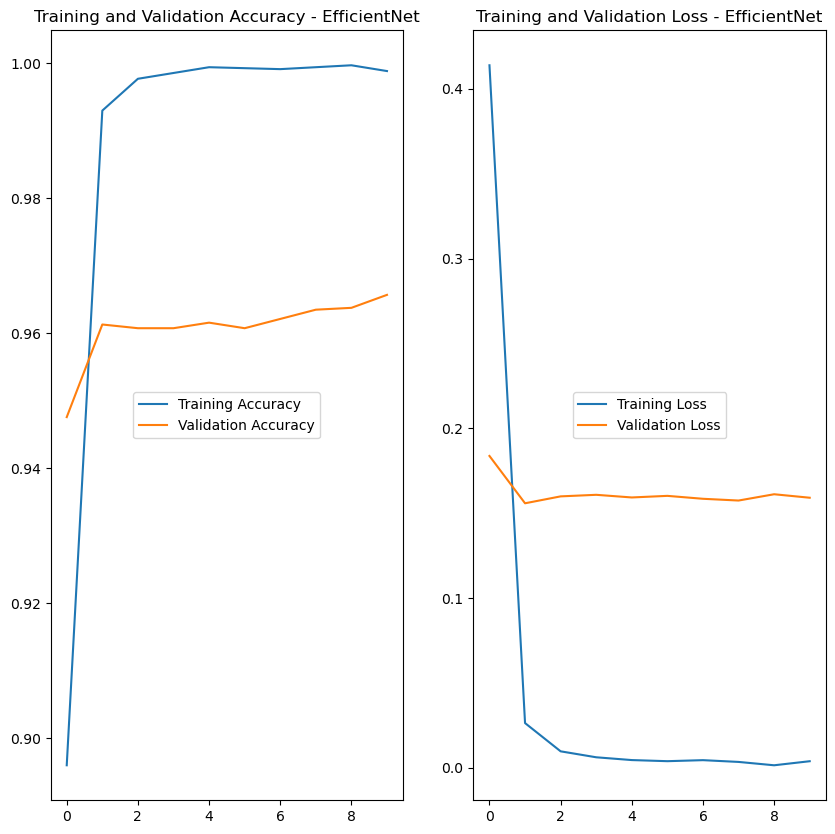

In [7]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center')
plt.title('Training and Validation Accuracy - EfficientNet')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center')
plt.title('Training and Validation Loss - EfficientNet')
plt.show()

In [8]:
predictions = model.predict(test_images)
predictions = list(map(np.argmax, predictions))

2023-06-13 23:14:41.843047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


55/55 [==============================] - 13s 217ms/step


In [9]:
print(classification_report(test_images.labels, predictions, target_names=list(test_images.class_indices.keys())))

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.88      0.83      0.85        70
     Allaple       0.99      1.00      0.99        70
   Amonetize       0.99      0.99      0.99        70
      Androm       0.90      0.89      0.89        70
     Autorun       0.93      0.91      0.92        70
   BrowseFox       0.99      0.99      0.99        70
      Dinwod       1.00      1.00      1.00        70
        Elex       0.96      0.99      0.97        70
      Expiro       0.89      0.94      0.92        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.97      0.86      0.91        70
 InstallCore       0.96      1.00      0.98        70
   MultiPlug       1.00      0.97      0.99        70
  Neoreklami       1.00      1.00      1.00        70
      Neshta       0.78    